In [32]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import neurogym as ngym
import logging
import warnings
from EI_network import EINet
from LeakyRNNNet import RNNNet
import torch.optim as optim
import matplotlib.pyplot as plt

Initalise the dataset 1

In [33]:
#Dataset loading 
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib.font_manager")

# Environment

task = 'PerceptualDecisionMakingDelayResponse-v0'
#task = 'PerceptualDecisionMaking-v0'
timing = {
    'fixation': ('choice', (50, 100, 200, 400)),
    'stimulus': ('choice', (100, 200, 400, 800)),
}

kwargs = {'dt': 20, 'timing': timing}
seq_len = 100

# Make supervised dataset
dataset = ngym.Dataset(task, env_kwargs=kwargs, batch_size=16,
                       seq_len=seq_len)

# A sample environment from dataset
env = dataset.env

# Network input and output size
input_size = env.observation_space.shape[0]
output_size = env.action_space.n

c:\Users\jidon\anaconda3\envs\PyTorch\Lib\site-packages\gym\utils\passive_env_checker.py:69: UserWarning: WARN: Agent's minimum action space value is -infinity. This is probably too low.
  logger.warn(
c:\Users\jidon\anaconda3\envs\PyTorch\Lib\site-packages\gym\utils\passive_env_checker.py:73: UserWarning: WARN: Agent's maximum action space value is infinity. This is probably too high
  logger.warn(
c:\Users\jidon\anaconda3\envs\PyTorch\Lib\site-packages\gym\utils\passive_env_checker.py:97: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  logger.warn(


In [34]:
ob1, gt1 = env.ob, env.gt

print(ob1,gt1)

indices_1 = np.where(ob1[:, 0] == 1)[0]

indices_0 = np.where(ob1[:, 0] == 0)[0]

indices_gt_1 = np.where(gt1 == 2)

print("Indices where first column is 1:", indices_1)
print("Indices where first column is 0:", indices_0)
print('For the gt',indices_gt_1)

[[1.         0.         0.        ]
 [1.         0.         0.        ]
 [1.         0.         0.        ]
 [1.         0.         0.        ]
 [1.         0.         0.        ]
 [1.         0.         0.        ]
 [1.         0.         0.        ]
 [1.         0.         0.        ]
 [1.         0.         0.        ]
 [1.         0.         0.        ]
 [1.         0.         0.        ]
 [1.         0.         0.        ]
 [1.         0.         0.        ]
 [1.         0.         0.        ]
 [1.         0.         0.        ]
 [1.         0.         0.        ]
 [1.         0.         0.        ]
 [1.         0.         0.        ]
 [1.         0.         0.        ]
 [1.         0.         0.        ]
 [1.         0.5789626  0.7374594 ]
 [1.         0.26392844 0.53992057]
 [1.         0.6317631  0.53760695]
 [1.         0.24764767 0.58360744]
 [1.         0.43881273 0.45587784]
 [1.         0.90998393 0.9289824 ]
 [1.         0.7063591  0.25562525]
 [1.         0.16533974 0.56

In [35]:
#EI net and LeakyRNN model initialisation, the number of parameter is fixed  
hidden_size = 50
e_prop = 0.8
EI_RNN = EINet(input_size=input_size, hidden_size=hidden_size,
          output_size=output_size, dt=env.dt, e_prop=e_prop, sigma_rec=0.15)
print(EI_RNN)

Leaky_RNN = RNNNet(input_size=input_size, hidden_size=hidden_size,
          output_size=output_size, dt=env.dt, e_prop=e_prop)
print(Leaky_RNN)

print("Parameters of EI_RNN:")
for name, param in EI_RNN.named_parameters():
    print(f"{name}: {param.shape}")

print("\nParameters of Leaky_RNN:")
for name, param in Leaky_RNN.named_parameters():
    print(f"{name}: {param.shape}")

EINet(
  (rnn): EIRNN(
    (input2h): Linear(in_features=3, out_features=50, bias=True)
    (h2h): EIRecLinear()
  )
  (fc): Linear(in_features=40, out_features=3, bias=True)
)
RNNNet(
  (rnn): LeakyRNN(
    (input2h): Linear(in_features=3, out_features=50, bias=True)
    (h2h): Linear(in_features=50, out_features=50, bias=True)
  )
  (fc): Linear(in_features=40, out_features=3, bias=True)
)
Parameters of EI_RNN:
rnn.input2h.weight: torch.Size([50, 3])
rnn.input2h.bias: torch.Size([50])
rnn.h2h.weight: torch.Size([50, 50])
rnn.h2h.bias: torch.Size([50])
fc.weight: torch.Size([3, 40])
fc.bias: torch.Size([3])

Parameters of Leaky_RNN:
rnn.input2h.weight: torch.Size([50, 3])
rnn.input2h.bias: torch.Size([50])
rnn.h2h.weight: torch.Size([50, 50])
rnn.h2h.bias: torch.Size([50])
fc.weight: torch.Size([3, 40])
fc.bias: torch.Size([3])


In [ ]:
# Train the EI_Net
optimizer_EI_RNN = optim.Adam(EI_RNN.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

loss_values = []  
running_loss_EI_RNN = 0.0
print_step = 200

for i in range(5000):
    inputs, labels = dataset()
    inputs = torch.from_numpy(inputs).type(torch.float)
    labels = torch.from_numpy(labels.flatten()).type(torch.long)

    # Zero the gradient buffers
    optimizer_EI_RNN.zero_grad()

    # Forward pass
    output, activity = EI_RNN(inputs)
    output = output.view(-1, output_size)

    # Compute loss
    loss = criterion(output, labels)

    # Backward pass
    loss.backward()

    # Update weights
    optimizer_EI_RNN.step()

    # Update running loss
    running_loss_EI_RNN += loss.item()
    if i % print_step == (print_step - 1):
        average_loss = running_loss_EI_RNN / print_step
        print('Step {}, Loss {:0.4f}'.format(i+1, average_loss))
        loss_values.append(average_loss) 
        running_loss_EI_RNN = 0.0


torch.save({
    'model_state_dict': EI_RNN.state_dict(),
    'optimizer_state_dict': optimizer_EI_RNN.state_dict(),
    'loss_values': loss_values,  
}, 'EI_RNN_model_task2.tar')

print("Model and optimizer state saved in EI_RNN_model_task2.tar")

Step 200, Loss 0.6198
Step 400, Loss 0.4023
Step 600, Loss 0.3650
Step 800, Loss 0.3378
Step 1000, Loss 0.3283
Step 1200, Loss 0.3139
Step 1400, Loss 0.3133
Step 1600, Loss 0.3028
Step 1800, Loss 0.2986
Step 2000, Loss 0.2958
Step 2200, Loss 0.2898
Step 2400, Loss 0.2891
Step 2600, Loss 0.2875
Step 2800, Loss 0.2850
Step 3000, Loss 0.2849
Step 3200, Loss 0.2818
Step 3400, Loss 0.2778
Step 3600, Loss 0.2848
Step 3800, Loss 0.2830
Step 4000, Loss 0.2839
Step 4200, Loss 0.2802
Step 4400, Loss 0.2764
Step 4600, Loss 0.2797
Step 4800, Loss 0.2825
Step 5000, Loss 0.2758
Model and optimizer state saved in EI_RNN_model_task2.tar


In [ ]:
# Train the Leaky RNN
optimizer_Leaky_RNN = optim.Adam(Leaky_RNN.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

Leaky_RNN_loss_values = []  
running_loss_Leaky_RNN = 0.0
print_step = 200

for i in range(5000):
    inputs, labels = dataset()
    inputs = torch.from_numpy(inputs).type(torch.float)
    labels = torch.from_numpy(labels.flatten()).type(torch.long)

    # Zero the gradient buffers
    optimizer_Leaky_RNN.zero_grad()

    # Forward pass
    output, activity,pool_hidden = Leaky_RNN(inputs)
    output = output.view(-1, output_size)

    # Compute loss
    loss = criterion(output, labels)

    # Backward pass
    loss.backward()

    # Update weights
    optimizer_Leaky_RNN.step()

    # Update running loss
    running_loss_Leaky_RNN += loss.item()
    if i % print_step == (print_step - 1):
        average_loss = running_loss_Leaky_RNN / print_step
        print('Step {}, Loss {:0.4f}'.format(i+1, average_loss))
        Leaky_RNN_loss_values.append(average_loss)  
        running_loss_Leaky_RNN = 0.0

torch.save({
    'model_state_dict': Leaky_RNN.state_dict(),
    'optimizer_state_dict': optimizer_Leaky_RNN.state_dict(),
    'loss_values': Leaky_RNN_loss_values,  
}, 'Leaky_RNN_model_task2.tar')

print("Model and optimizer state saved in Leaky_RNN_model_task2.tar")

Step 200, Loss 0.6051
Step 400, Loss 0.4152
Step 600, Loss 0.3770
Step 800, Loss 0.3513
Step 1000, Loss 0.3383
Step 1200, Loss 0.3309
Step 1400, Loss 0.3274
Step 1600, Loss 0.3206
Step 1800, Loss 0.3178
Step 2000, Loss 0.3085
Step 2200, Loss 0.3054
Step 2400, Loss 0.2995
Step 2600, Loss 0.2980
Step 2800, Loss 0.2966
Step 3000, Loss 0.2958
Step 3200, Loss 0.2843
Step 3400, Loss 0.2853
Step 3600, Loss 0.2881
Step 3800, Loss 0.2844
Step 4000, Loss 0.2828
Step 4200, Loss 0.2780
Step 4400, Loss 0.2842
Step 4600, Loss 0.2808
Step 4800, Loss 0.2817
Step 5000, Loss 0.2789
Model and optimizer state saved in Leaky_RNN_model_task2.tar


25
25


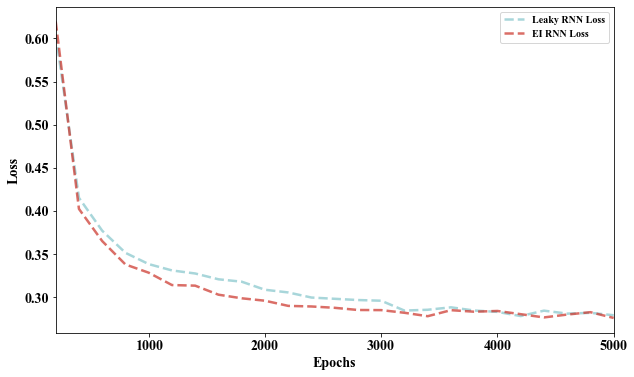

In [ ]:
print(len(Leaky_RNN_loss_values))
print(len(loss_values))

epoch = np.linspace(200, 5000,len(Leaky_RNN_loss_values))

plt.figure(figsize=(10, 6))
plt.plot(epoch, Leaky_RNN_loss_values, label='Leaky RNN Loss', linewidth=2.5, color='#84c5cb', linestyle='--', alpha=0.7)
plt.plot(epoch, loss_values, label='EI RNN Loss', linewidth=2.5, color='#cb3127', linestyle='--', alpha=0.7)

plt.xlabel('Epochs', fontsize=14, fontweight='bold', fontfamily='Times New Roman')
plt.ylabel('Loss', fontsize=14, fontweight='bold', fontfamily='Times New Roman')
plt.legend(fontsize=14, loc='upper right', prop={'weight': 'bold', 'family': 'Times New Roman'})
plt.xticks(fontsize=14, fontweight='bold', fontfamily='Times New Roman')
plt.yticks(fontsize=14, fontweight='bold', fontfamily='Times New Roman')
plt.grid(False)
plt.xlim([200, 5000])


save_path = r"C:\Users\jidon\OneDrive - University of Bristol\Home Desktop\Year4\Cog AI\Coursework\Pic\loss_plot_task2.png"
plt.savefig(save_path, dpi=600, bbox_inches='tight', facecolor='white', edgecolor='white')

plt.show()

Starting analysising the network 

In [ ]:
#initalise the test set basically 
env.reset(no_step=True)
env.timing.update({'fixation': ('constant', 500),
                   'stimulus': ('constant', 500)})
num_trial = 5000
#num_trial = 2
# EI_RNN net execution
ei_perf = 0
ei_activity_dict = {}
ei_trial_infos = {}
ei_stim_activity = [[], []]  
for i in range(num_trial):
    env.new_trial()
    ob, gt = env.ob, env.gt
    inputs = torch.from_numpy(ob[:, np.newaxis, :]).type(torch.float)
    ei_action_pred, ei_rnn_activity = EI_RNN(inputs)  
    #print(ei_rnn_activity.shape)
 
    ei_action_pred = ei_action_pred.detach().numpy()
    ei_choice = np.argmax(ei_action_pred[-1, 0, :])
    #print(ei_choice)
    #print(gt[-1])
    ei_correct = ei_choice == gt[-1]

    # Log trial info for EI_RNN
    ei_trial_info = env.trial
    ei_trial_info.update({'correct': ei_correct, 'choice': ei_choice})
    ei_trial_infos[i] = ei_trial_info

    # Log stimulus period activity for EI_RNN
    
    ei_rnn_activity = ei_rnn_activity[:, 0, :].detach().numpy()
    
    ei_activity_dict[i] = ei_rnn_activity
    #print(f"Trial {i}: Ground truth value = {env.trial['ground_truth']}")
    # Compute stimulus selectivity for EI_RNN
    ei_rnn_activity = ei_rnn_activity[env.start_ind['stimulus']: env.end_ind['stimulus']]
    ei_stim_activity[env.trial['ground_truth']-1].append(ei_rnn_activity) 

print('Average performance for EI_RNN:', np.mean([val['correct'] for val in ei_trial_infos.values()]))


Average performance for EI_RNN: 0.4994


In [ ]:
env.reset(no_step=True)
env.timing.update({'fixation': ('constant', 500),
                   'stimulus': ('constant', 500)})


leaky_perf = 0
leaky_activity_dict = {}
leaky_trial_infos = {}
leaky_stim_activity = [[], []]  
num_trial = 5000
for i in range(num_trial):
    env.new_trial()
    ob, gt = env.ob, env.gt
    inputs = torch.from_numpy(ob[:, np.newaxis, :]).type(torch.float)
    leaky_action_pred, leaky_rnn_activity, pool_hidden_test = Leaky_RNN(inputs) 

    # Compute performance for Leaky_RNN
    leaky_action_pred = leaky_action_pred.detach().numpy()
    leaky_choice = np.argmax(leaky_action_pred[-1, 0, :])
    leaky_correct = leaky_choice == gt[-1]

    # Log trial info for Leaky_RNN
    leaky_trial_info = env.trial
    leaky_trial_info.update({'correct': leaky_correct, 'choice': leaky_choice})
    leaky_trial_infos[i] = leaky_trial_info

    # Log stimulus period activity for Leaky_RNN
    leaky_rnn_activity = leaky_rnn_activity[:, 0, :].detach().numpy()
    leaky_activity_dict[i] = leaky_rnn_activity

    # Compute stimulus selectivity for Leaky_RNN
    leaky_rnn_activity = leaky_rnn_activity[env.start_ind['stimulus']: env.end_ind['stimulus']]  
    leaky_stim_activity[env.trial['ground_truth']-1].append(leaky_rnn_activity)

print('Average performance for Leaky_RNN:', np.mean([val['correct'] for val in leaky_trial_infos.values()]))

Average performance for Leaky_RNN: 0.4854


Processing EI_RNN...


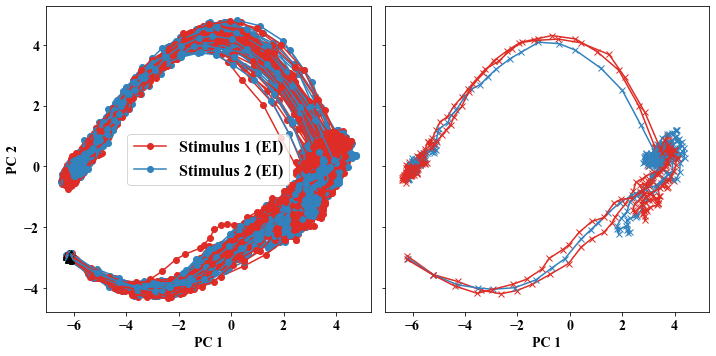

In [ ]:

from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
import logging

logging.getLogger("matplotlib").setLevel(logging.CRITICAL)

num_trial = 500  
plot_until_time = 300 # Basically plot all 


print("Processing EI_RNN...")
ei_activity = np.concatenate([ei_activity_dict[i] for i in range(num_trial)], axis=0)

ei_pca = PCA(n_components=2)
ei_pca.fit(ei_activity) 
ei_activity_pc = ei_pca.transform(ei_activity)

fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10, 5))

for i in range(100):
    ei_activity_pc = ei_pca.transform(ei_activity_dict[i])
    
    trial = ei_trial_infos[i]
    #print(trial['ground_truth'])
    color = '#de2d26' if trial['ground_truth'] == 1 else '#3182bd'

    ax1.plot(ei_activity_pc[:plot_until_time, 0], ei_activity_pc[:plot_until_time, 1], 'o-', color=color, label='Stimulus 1 (EI)' if trial['ground_truth'] == 1 else 'Stimulus 2 (EI)')
    
    if i < 3:

        ax2.plot(ei_activity_pc[:plot_until_time, 0], ei_activity_pc[:plot_until_time, 1], 'x-', color=color)


    ax1.plot(ei_activity_pc[0, 0], ei_activity_pc[0, 1], '^', color='black')


handles, labels = ax1.get_legend_handles_labels()



unique_handles_labels = dict(zip(labels, handles))  

ordered_labels = ['Stimulus 1 (EI)', 'Stimulus 2 (EI)']
ordered_handles = [unique_handles_labels[label] for label in ordered_labels]

ax1.legend(ordered_handles, ordered_labels, loc='best', 
           fontsize=14, frameon=True, prop={'weight': 'bold', 'size': 16, 'family': 'Times New Roman'})



ax1.set_xlabel('PC 1', fontsize=14, fontweight='bold', fontfamily='Times New Roman')
ax1.set_ylabel('PC 2', fontsize=14, fontweight='bold', fontfamily='Times New Roman')
ax2.set_xlabel('PC 1', fontsize=14, fontweight='bold', fontfamily='Times New Roman')


plt.tight_layout()
for ax in [ax1, ax2]:
    ax.tick_params(axis='both', which='major', labelsize=14)
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontweight('bold')
        label.set_fontfamily('Times New Roman')


save_path = r"C:\Users\jidon\OneDrive - University of Bristol\Home Desktop\Year4\Cog AI\Coursework\Pic\EI_RNN_task2_plot_a_PCA.png"
plt.savefig(save_path, dpi=600, bbox_inches='tight', facecolor='white', edgecolor='white')
plt.show()

Processing EI_RNN...


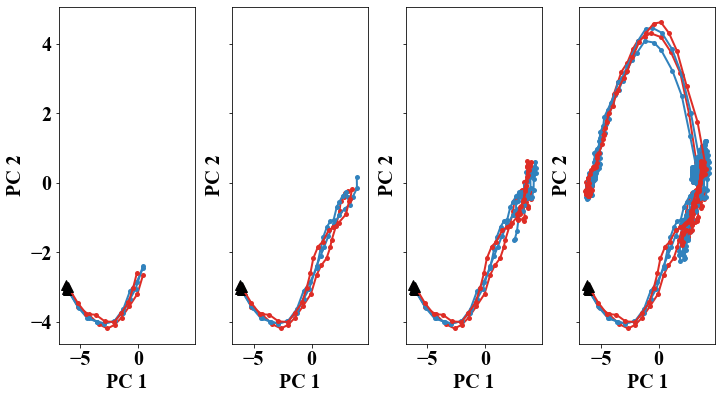

In [ ]:
import logging
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

logging.getLogger("matplotlib").setLevel(logging.CRITICAL)

num_trial = 500  
plot_until_time = 70  # Basically plot all


print("Processing EI_RNN...")
ei_activity = np.concatenate([ei_activity_dict[i] for i in range(num_trial)], axis=0)

ei_pca = PCA(n_components=2)
ei_pca.fit(ei_activity)  
ei_activity_pc = ei_pca.transform(ei_activity)

time_intervals = [10, 20, 40, 300]

fig, axs = plt.subplots(1, 4, figsize=(10, 6), sharex=True, sharey=True)  

plot_indices = [0,1,5,10]
#plot_indices = [0, 1, 2, 15]

for ax, time_end in zip(axs, time_intervals):
    for i in plot_indices: 
        ei_activity_pc = ei_pca.transform(ei_activity_dict[i])

        trial = ei_trial_infos[i]
        color = '#de2d26' if trial['ground_truth'] == 1 else '#3182bd'

        ax.plot(ei_activity_pc[:time_end, 0], ei_activity_pc[:time_end, 1], 'o-', color=color, linewidth=2,markersize=2, markeredgewidth=3)
        ax.plot(ei_activity_pc[0, 0], ei_activity_pc[0, 1], '^', color='k', markersize=10)  

    ax.set_xlabel('PC 1', fontsize=20, fontweight='bold', fontfamily='Times New Roman')
    ax.set_ylabel('PC 2', fontsize=20, fontweight='bold', fontfamily='Times New Roman')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])

for ax in axs:
    ax.tick_params(axis='both', which='major', labelsize=20)
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontweight('bold')
        label.set_fontfamily('Times New Roman')


save_path = r"C:\Users\jidon\OneDrive - University of Bristol\Home Desktop\Year4\Cog AI\Coursework\Pic\EI_RNN_task2_plot_b_PCA.png"
plt.savefig(save_path, dpi=600, bbox_inches='tight', facecolor='white', edgecolor='white')
plt.show()

Processing Leaky_RNN...
Leaky_RNN Neural Activity Shape: (100720, 50)
Leaky_RNN Projected Activity Shape: (100720, 2)


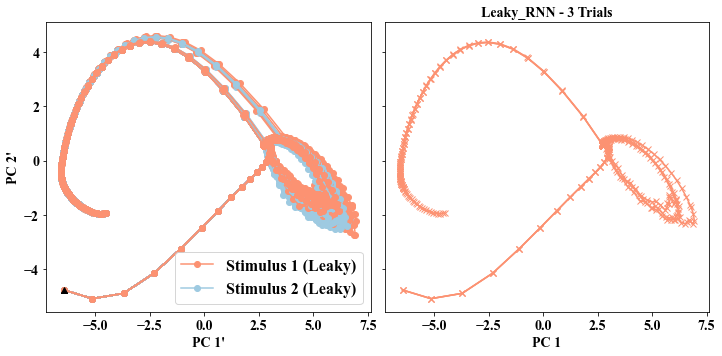

In [ ]:
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
import logging

logging.getLogger("matplotlib").setLevel(logging.CRITICAL)

num_trial = 500  
plot_until_time = 300  # Basically plot all 

print("Processing Leaky_RNN...")
leaky_activity_all = np.concatenate([leaky_activity_dict[i] for i in range(num_trial)], axis=0)
print('Leaky_RNN Neural Activity Shape:', leaky_activity_all.shape)

leaky_pca_model = PCA(n_components=2)
leaky_pca_model.fit(leaky_activity_all)
leaky_activity_projected = leaky_pca_model.transform(leaky_activity_all)
print('Leaky_RNN Projected Activity Shape:', leaky_activity_projected.shape)

fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10, 5))

for i in range(100):
    leaky_activity_per_trial = leaky_pca_model.transform(leaky_activity_dict[i])
    trial_info = leaky_trial_infos[i]
    color = '#fc9272' if trial_info['ground_truth'] == 1 else '#9ecae1'

  
    ax1.plot(leaky_activity_per_trial[:plot_until_time, 0], leaky_activity_per_trial[:plot_until_time, 1], 
             'o-', color=color, label='Stimulus 1 (Leaky)' if trial_info['ground_truth'] == 1 else 'Stimulus 2 (Leaky)')
    
    if i < 3:
        ax2.plot(leaky_activity_per_trial[:plot_until_time, 0], leaky_activity_per_trial[:plot_until_time, 1], 
                 'x-', color=color)


    ax1.plot(leaky_activity_per_trial[0, 0], leaky_activity_per_trial[0, 1], '^', color='black')


handles, labels = ax1.get_legend_handles_labels()

#print(unique_handles_labels.keys())
unique_handles_labels = dict(zip(labels, handles))  
ax1.legend(unique_handles_labels.values(), unique_handles_labels.keys(), loc='best', 
           fontsize=14, frameon=True, prop={'weight': 'bold', 'size': 16, 'family': 'Times New Roman'})

ax2.set_title('Leaky_RNN - 3 Trials', fontsize=14, fontweight='bold', fontfamily='Times New Roman')
ax1.set_xlabel("PC 1'", fontsize=14, fontweight='bold', fontfamily='Times New Roman')
ax1.set_ylabel("PC 2'", fontsize=14, fontweight='bold', fontfamily='Times New Roman')
ax2.set_xlabel('PC 1', fontsize=14, fontweight='bold', fontfamily='Times New Roman')

plt.tight_layout()
for ax in [ax1, ax2]:
    ax.tick_params(axis='both', which='major', labelsize=14)
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontweight('bold')
        label.set_fontfamily('Times New Roman')

save_path_leaky = r"C:\Users\jidon\OneDrive - University of Bristol\Home Desktop\Year4\Cog AI\Coursework\Pic\Leaky_RNN_task2_plot_a_PCA.png"
plt.savefig(save_path_leaky, dpi=600, bbox_inches='tight', facecolor='white', edgecolor='white')
plt.show()

Processing Leaky_RNN...


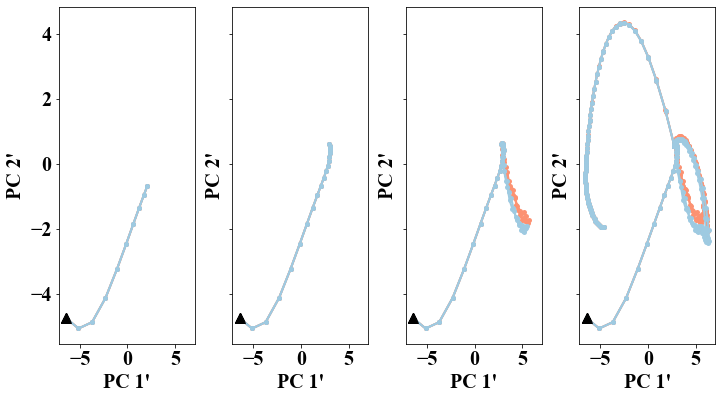

In [ ]:
logging.getLogger("matplotlib").setLevel(logging.CRITICAL)

num_trial = 500  
plot_until_time = 300  # Basically plot all


print("Processing Leaky_RNN...")
leaky_activity = np.concatenate([leaky_activity_dict[i] for i in range(num_trial)], axis=0)

leaky_pca = PCA(n_components=2)
leaky_pca.fit(leaky_activity)  
leaky_activity_pc = leaky_pca.transform(leaky_activity)

time_intervals = [10, 20, 40, -1]

fig, axs = plt.subplots(1, 4, figsize=(10, 6), sharex=True, sharey=True)  

plot_indices = [0,1,8,9]

for ax, time_end in zip(axs, time_intervals):
    for i in plot_indices:  
        leaky_activity_pc = leaky_pca.transform(leaky_activity_dict[i])

        trial = leaky_trial_infos[i]
        color = '#fc9272' if trial['ground_truth'] == 1 else '#9ecae1' 

        ax.plot(leaky_activity_pc[:time_end, 0], leaky_activity_pc[:time_end, 1], 
                'o-', color=color, linewidth=2,markersize=2, markeredgewidth=3)  

        ax.plot(leaky_activity_pc[0, 0], leaky_activity_pc[0, 1], '^', color='k', markersize=10)

    ax.set_xlabel("PC 1'", fontsize=20, fontweight='bold', fontfamily='Times New Roman')
    ax.set_ylabel("PC 2'", fontsize=20, fontweight='bold', fontfamily='Times New Roman')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
for ax in axs:
    ax.tick_params(axis='both', which='major', labelsize=20)
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontweight('bold')
        label.set_fontfamily('Times New Roman')

# Save the plot
save_path_leaky = r"C:\Users\jidon\OneDrive - University of Bristol\Home Desktop\Year4\Cog AI\Coursework\Pic\Leaky_RNN_task2_plot_b_PCA.png"
plt.savefig(save_path_leaky, dpi=600, bbox_inches='tight', facecolor='white', edgecolor='white')
plt.show()

Lesioning the network

In [ ]:
#for EI
e_size = EI_RNN.rnn.e_size  

mean_activity = []
std_activity = []
for ground_truth in [0, 1]:
    activity = np.concatenate(ei_stim_activity[ground_truth], axis=0)
    print(activity.shape)
    mean_activity.append(np.mean(activity, axis=0)) 
    std_activity.append(np.std(activity, axis=0))

# Compute d'
selectivity = (mean_activity[0] - mean_activity[1])
selectivity /= np.sqrt((std_activity[0]**2 + std_activity[1]**2 + 1e-7) / 2)

# Sort index for selectivity, separately for E and I
ind_sort = np.concatenate((np.argsort(selectivity[:e_size]),
                           np.argsort(selectivity[e_size:]) + e_size)) # adding e_size to make the selection in the absolute frame of reference 

# Define a threshold to identify top contributing neurons (e.g., top 20% based on selectivity)
lesion_fraction = 0.2

num_neurons_to_lesion = int(lesion_fraction * EI_RNN.rnn.hidden_size)  # Lesion top 20% most selective neurons
selective_neurons = np.argsort(np.abs(selectivity))[-num_neurons_to_lesion:]  # Indices of most selective neurons

def lesion_network(net, selective_neurons):
    with torch.no_grad():  
        net.rnn.h2h.weight[selective_neurons, :] = 0
        net.rnn.h2h.weight[:, selective_neurons] = 0


initial_weights = EI_RNN.rnn.h2h.weight.clone()


lesion_network(EI_RNN, selective_neurons)


loss_values_lesioned = []  
running_loss_lesioned = 0.0

print('Evaluating EI_RNN after lesioning top 20% of neurons...')
for i in range(300):  
    inputs, labels = dataset()  
    inputs = torch.from_numpy(inputs).type(torch.float)
    labels = torch.from_numpy(labels.flatten()).type(torch.long)

    # Zero the gradient buffers
    optimizer_EI_RNN.zero_grad()

    # Forward pass
    output, activity = EI_RNN(inputs)
    output = output.view(-1, output_size)

    # Compute loss
    loss = criterion(output, labels)  

    # Update running loss
    running_loss_lesioned += loss.item()
    if i % print_step == (print_step - 1): 
        average_loss = running_loss_lesioned / print_step
        print('Step {}, Lesioned Network Loss {:0.4f}'.format(i + 1, average_loss))
        loss_values_lesioned.append(average_loss)
        running_loss_lesioned = 0.0

EI_RNN.rnn.h2h.weight = nn.Parameter(initial_weights)

(62775, 50)
(62225, 50)
Evaluating EI_RNN after lesioning top 20% of neurons...
Step 200, Lesioned Network Loss 0.3239


###Fix point 

In [ ]:
import sys
sys.path.append(r"C:\Users\jidon\OneDrive - University of Bristol\Home Desktop\Year4\Cog AI\Coursework\fixed-point-finder")

from FixedPointFinderTorch import FixedPointFinderTorch as FixedPointFinder
import torch

In [ ]:

class FixedPointRNNWrapper(torch.nn.Module):
    def __init__(self, rnn, batch_first=False):
        super(FixedPointRNNWrapper, self).__init__()
        self.rnn = rnn
        self.batch_first = batch_first 
        #print(batch_first.shape)

    def forward(self, input, hidden):

        hidden = hidden.squeeze(0)


        output, hidden = self.rnn(input, hidden)

        hidden = hidden.unsqueeze(0)

        return None, hidden

In [ ]:
# For the EI net 
rnn_model_fixed_point = FixedPointRNNWrapper(EI_RNN.rnn, batch_first=False)

finder = FixedPointFinder(rnn_model_fixed_point) 


initial_conditions = torch.randn(100, EI_RNN.rnn.hidden_size)  
print(initial_conditions.shape)
inputs = torch.zeros(100, EI_RNN.rnn.input_size)  
print(inputs.shape)

init_hidden_np = initial_conditions.cpu().numpy()
inputs_np = inputs.cpu().numpy()

fixed_points_result = finder.find_fixed_points(initial_states=init_hidden_np, inputs=inputs_np)

fps = fixed_points_result[0]  

fixed_points = fps.xstar 

torch.Size([100, 50])
torch.Size([100, 3])

Searching for fixed points from 100 initial states.

	Freezing model parameters so model is not affected by fixed point optimization.
	Finding fixed points via joint optimization.
	Maximum iteration count reached. Terminating.
		5000 iters
		q = 1.17e-01 +/- 3.00e-02
		dq = 3.38e-02 +/- 2.45e-02
		learning rate = 1.97e-07
		avg iter time = 1.27e-03 sec
	Identified 100 unique fixed points.
		initial_states: 0 outliers detected (of 100).
		fixed points: 0 outliers detected (of 100).
	Computing recurrent Jacobian at 100 unique fixed points.
	Computing input Jacobian at 100 unique fixed points.
	Decomposing Jacobians in a single batch.
	Sorting by Eigenvalue magnitude.
	Fixed point finding complete.



In [ ]:
print((fps.J_xstar).shape)
aaa = fps.J_xstar
stability_results = []
for i, J in enumerate(aaa):
    eigenvalues = np.linalg.eigvals(J)
    stable = np.all(np.abs(eigenvalues) < 1)  
    stability_results.append((i + 1, eigenvalues, "Stable" if stable else "Unstable"))

#print(stability_results)


import pandas as pd
stability_df = pd.DataFrame(stability_results, columns=["Fixed Point", "Eigenvalues", "Stability"])
with pd.option_context('display.max_rows', None, 'display.max_colwidth', None):
    display(stability_df)


(100, 50, 50)


,Fixed Point,Eigenvalues,Stability
0,1,"[(0.8+0j), (0.8+0j), (0.80225706+0.11551648j), (0.80225706-0.11551648j), (0.8350798+0.062077764j), (0.8350798-0.062077764j), (0.8361933+0.014770581j), (0.8361933-0.014770581j), (0.76254034+0.02818409j), (0.76254034-0.02818409j), (0.7568728+0j), (0.7679388+0.015159649j), (0.7679388-0.015159649j), (0.8093846+0.023067115j), (0.8093846-0.023067115j), (0.80326164+0.013933476j), (0.80326164-0.013933476j), (0.8047734+0.004474648j), (0.8047734-0.004474648j), (0.79733384+0j), (0.8029359+0j), (0.8+0j), 0j, 0j, (0.8+0j), 0j, 0j, 0j, 0j, (0.8+0j), 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, (0.8+0j), 0j]",Stable
1,2,"[(0.81296027+0.13944153j), (0.81296027-0.13944153j), (0.859977+0.029204447j), (0.859977-0.029204447j), (0.7400095+0j), (0.78352565+0.057828035j), (0.78352565-0.057828035j), (0.8013776+0.05741238j), (0.8013776-0.05741238j), (0.8100005+0.051711515j), (0.8100005-0.051711515j), (0.7563887+0.0036625098j), (0.7563887-0.0036625098j), (0.77181077+0.027727997j), (0.77181077-0.027727997j), (0.80879754+0.042240735j), (0.80879754-0.042240735j), (0.83799654+0j), (0.78773564+0.018383725j), (0.78773564-0.018383725j), (0.7970905+0j), (0.8084967+0.0101371j), (0.8084967-0.0101371j), (0.81138146+0.0017634222j), (0.81138146-0.0017634222j), (0.8+0j), 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, (0.8+0j), 0j]",Stable
2,3,"[(0.8+0j), (0.94744855+0j), (0.76045835+0.13390145j), (0.76045835-0.13390145j), (0.784562+0.09742948j), (0.784562-0.09742948j), (0.7353339+0j), (0.84060407+0.021103738j), (0.84060407-0.021103738j), (0.8029257+0.04122895j), (0.8029257-0.04122895j), (0.76542336+0.020828301j), (0.76542336-0.020828301j), (0.80377704+0.028555807j), (0.80377704-0.028555807j), (0.82698315+0j), (0.7952169+0.013434711j), (0.7952169-0.013434711j), (0.7848392+0j), (0.79095745+0j), (0.80428284+0.0021548476j), (0.80428284-0.0021548476j), (0.7999374+0j), (0.8+0j), (0.8+0j), (0.8+0j), (0.8+0j), 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, (0.8+0j), 0j]",Stable
3,4,"[(0.8+0j), (0.951826+0j), (0.7739583+0.13621755j), (0.7739583-0.13621755j), (0.7742876+0.091635875j), (0.7742876-0.091635875j), (0.7361471+0j), (0.7753608+0.04881857j), (0.7753608-0.04881857j), (0.7568784+0.01965577j), (0.7568784-0.01965577j), (0.84358686+0.04364413j), (0.84358686-0.04364413j), (0.8070953+0.050552566j), (0.8070953-0.050552566j), (0.8239175+0.027675055j), (0.8239175-0.027675055j), (0.8337784+0j), (0.807915+0.021558758j), (0.807915-0.021558758j), (0.7749603+0j), (0.7912387+0.0069356575j), (0.7912387-0.0069356575j), (0.8001106+0.0021774583j), (0.8001106-0.0021774583j), (0.7945904+0j), (0.8+0j), 0j, (0.8+0j), 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, (0.8+0j), 0j]",Stable
4,5,"[(0.8+0j), (0.8021461+0.11029255j), (0.8021461-0.11029255j), (0.7471058+0.03490044j), (0.7471058-0.03490044j), (0.83012056+0.05305076j), (0.83012056-0.05305076j), (0.8327674+0.023786522j), (0.8327674-0.023786522j), (0.7812117+0.031363122j), (0.7812117-0.031363122j), (0.777842+0j), (0.8225817+0j), (0.78753847+0j), (0.813169+0.0067877253j), (0.813169-0.0067877253j), (0.79636747+0.010928308j), (0.79636747-0.010928308j), (0.80757165+0j), (0.7973578+0j), (0.8013327+0j), (0.8+0j), (0.8+0j), (0.8+0j), (0.8+0j), 0j, (0.8+0j), 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, (0.8+0j), 0j]",Stable
5,6,"[(0.81286633+0.10346758j), (0.81286633-0.10346758j), (0.72910917+0j), (0.82557553+0.056301355j), (0.82557553-0.056301355j), (0.78906685+0.058006357j), (0.78906685-0.058006357j), (0.7562335+0.026381971j), (0.7562335-0.026381971j), (0.8468442+0j), (0.83028334+0.029435307j), (0.83028334-0.029435307j), (0.82351166+0j), (0.7799785+0j), (0.81180006+0.004897022j), (0.81180006-0.004897022j), (0.79049736+0.011306636j), (0.79049736-0.011306636j), (0.7887505+0j), (0.8017562+0.0014027206j), (0.8017562-0.0014027206j), (0.797

(1024180, 50)
(100, 50)


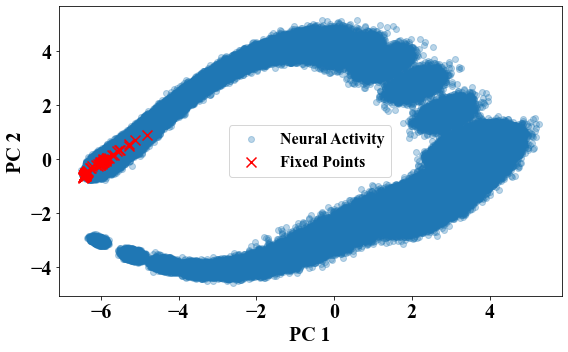

In [ ]:
activity_list = []
for trial_activity in ei_activity_dict.values():
    activity_list.append(trial_activity)  
activity = np.vstack(activity_list)  


fixed_points_array = np.vstack(fixed_points)  

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)

activity_and_fp = np.concatenate([activity, fixed_points_array], axis=0) 
pca.fit(activity_and_fp)
print(activity.shape)
print(fixed_points_array.shape)

activity_pc = pca.transform(activity)
fixed_points_pc = pca.transform(fixed_points_array)


plt.figure(figsize=(8, 5))
plt.scatter(activity_pc[:, 0], activity_pc[:, 1], alpha=0.3, label='Neural Activity')
plt.scatter(fixed_points_pc[:, 0], fixed_points_pc[:, 1], color='red', marker='x', s=100, label='Fixed Points')


plt.xlabel("PC 1", fontsize=20, fontweight='bold', fontfamily='Times New Roman')
plt.ylabel("PC 2", fontsize=20, fontweight='bold', fontfamily='Times New Roman')

plt.legend(
    prop={
        'size': 16, 
        'weight': 'bold',
        'family': 'Times New Roman'
    },
    loc='best' 
)

plt.xticks(fontsize=20, fontweight='bold', fontfamily='Times New Roman')
plt.yticks(fontsize=20, fontweight='bold', fontfamily='Times New Roman')

save_path_leaky = r"C:\Users\jidon\OneDrive - University of Bristol\Home Desktop\Year4\Cog AI\Coursework\Pic\EI_RNN_task2_plot_fp_PCA.png"
plt.tight_layout()
plt.savefig(save_path_leaky, dpi=600, bbox_inches='tight', facecolor='white', edgecolor='white')

plt.show()


Searching for fixed points from 100 initial states.

	Freezing model parameters so model is not affected by fixed point optimization.
	Finding fixed points via joint optimization.
	Maximum iteration count reached. Terminating.
		5000 iters
		q = 9.57e-02 +/- 2.84e-02
		dq = 3.13e-02 +/- 2.41e-02
		learning rate = 1.97e-07
		avg iter time = 1.18e-03 sec
	Identified 100 unique fixed points.
		initial_states: 0 outliers detected (of 100).
		fixed points: 0 outliers detected (of 100).
	Computing recurrent Jacobian at 100 unique fixed points.
	Computing input Jacobian at 100 unique fixed points.
	Decomposing Jacobians in a single batch.
	Sorting by Eigenvalue magnitude.
	Fixed point finding complete.


Searching for fixed points from 100 initial states.

	Freezing model parameters so model is not affected by fixed point optimization.
	Finding fixed points via joint optimization.
	Maximum iteration count reached. Terminating.
		5000 iters
		q = 1.02e-01 +/- 2.93e-02
		dq = 3.73e-02 +/- 2.54

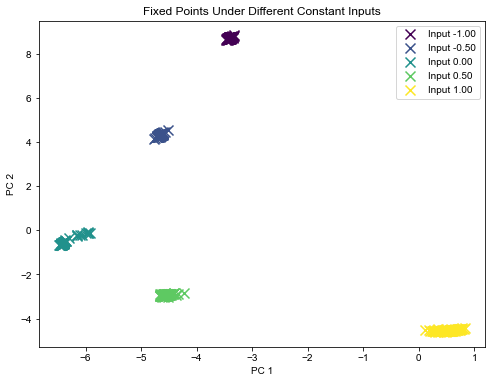

In [ ]:

input_values = np.linspace(-1, 1, 5) 
fixed_points_by_input = []

for input_val in input_values:

    inputs_np = np.full((100, EI_RNN.input_size), input_val)  

    init_hidden_np = initial_conditions.cpu().numpy()

    fps_result = finder.find_fixed_points(initial_states=init_hidden_np, inputs=inputs_np)
    fps = fps_result[0]
    fixed_points_by_input.append((input_val, fps.xstar))


plt.figure(figsize=(8, 6))
colors = plt.cm.viridis(np.linspace(0, 1, len(input_values)))

for idx, (input_val, fp_array) in enumerate(fixed_points_by_input):
    fp_pc = pca.transform(fp_array)
    plt.scatter(fp_pc[:, 0], fp_pc[:, 1], color=colors[idx], marker='x', s=100, label=f'Input {input_val:.2f}')

plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('Fixed Points Under Different Constant Inputs')
plt.legend()
plt.show()


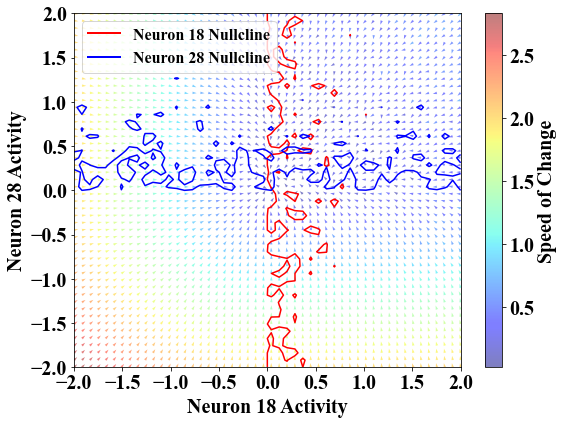

In [ ]:
from matplotlib.lines import Line2D
selectivity_indices = np.argsort(np.abs(selectivity))[-2:]
neuron1, neuron2 = selectivity_indices


n_points = 50
state_range = np.linspace(-2, 2, n_points)
neuron1_states, neuron2_states = np.meshgrid(state_range, state_range)

grid_states = np.c_[neuron1_states.ravel(), neuron2_states.ravel()]

inputs = torch.zeros(grid_states.shape[0], EI_RNN.input_size).type(torch.float32)

initial_states = np.zeros((grid_states.shape[0], EI_RNN.rnn.hidden_size))
initial_states[:, neuron1] = grid_states[:, 0]
initial_states[:, neuron2] = grid_states[:, 1]

initial_states_tensor = torch.from_numpy(initial_states).type(torch.float32)

_, next_states = EI_RNN.rnn(inputs.unsqueeze(0), initial_states_tensor)
next_states = next_states.detach().cpu().numpy()

d_neuron1 = next_states[:, neuron1] - initial_states[:, neuron1]
d_neuron2 = next_states[:, neuron2] - initial_states[:, neuron2]

d_neuron1_grid = d_neuron1.reshape(neuron1_states.shape)
d_neuron2_grid = d_neuron2.reshape(neuron2_states.shape)

U = d_neuron1_grid  
V = d_neuron2_grid  

speed = np.sqrt(U**2 + V**2)
U_norm = U / speed
V_norm = V / speed

plt.figure(figsize=(8, 6))
plt.contour(neuron1_states, neuron2_states, d_neuron1_grid, levels=[0], colors='red')
plt.contour(neuron1_states, neuron2_states, d_neuron2_grid, levels=[0], colors='blue')
quiver = plt.quiver(neuron1_states, neuron2_states, U_norm, V_norm, speed, cmap='jet', alpha=0.5)

legend_elements = [Line2D([0], [0], color='red', lw=2, label=f'Neuron {neuron1} Nullcline'),
                   Line2D([0], [0], color='blue', lw=2, label=f'Neuron {neuron2} Nullcline')]

plt.legend(
    handles=legend_elements,
    loc='upper left',  
    prop={
        'size': 16,  
        'weight': 'bold',
        'family': 'Times New Roman'
    }
)


plt.xlabel(f'Neuron {neuron1} Activity', fontsize=20, fontweight='bold', fontfamily='Times New Roman')
plt.ylabel(f'Neuron {neuron2} Activity', fontsize=20, fontweight='bold', fontfamily='Times New Roman')
#plt.title('Nullclines and Vector Fields', fontsize=14, fontweight='bold', fontfamily='Times New Roman')


plt.xticks(fontsize=20, fontweight='bold', fontfamily='Times New Roman')
plt.yticks(fontsize=20, fontweight='bold', fontfamily='Times New Roman')


cbar = plt.colorbar(quiver)
cbar.set_label('Speed of Change', fontsize=20, fontweight='bold', fontfamily='Times New Roman')
cbar.ax.tick_params(labelsize=20)
for label in cbar.ax.get_yticklabels():
    label.set_fontweight('bold')
    label.set_fontfamily('Times New Roman')

save_path_leaky = r"C:\Users\jidon\OneDrive - University of Bristol\Home Desktop\Year4\Cog AI\Coursework\Pic\EI_RNN_task2_plot_nuclines.png"
plt.tight_layout()
plt.savefig(save_path_leaky, dpi=600, bbox_inches='tight', facecolor='white', edgecolor='white')

plt.show()

In [53]:
print(neuron1, neuron2)
print(selectivity)

18 28
[-0.32268235  0.00505323  0.6319601   0.18096898 -0.23506686 -0.24340658
  0.26871046 -0.31115794 -0.33651823  0.4749714   0.21394177  0.18264538
 -0.00143943  0.07477231 -0.57453734  0.42139652 -0.03320566  0.2501469
  0.63577574 -0.2806081  -0.0702678   0.03408355  0.3048303   0.14842413
 -0.433539    0.51374507  0.17695336  0.11886998 -0.72119725 -0.02193389
 -0.08545805  0.06027727  0.49051705  0.31838268  0.20654324 -0.09161488
  0.01675848  0.5215254  -0.12013157  0.06998307 -0.02948352  0.0837758
 -0.2990034  -0.25332102  0.00527642 -0.20026915  0.09773938  0.35531193
  0.16077352  0.30318457]


For Leaky RNN

In [ ]:
#for leaky RNN lession
e_size_Leaky_RNN = Leaky_RNN.e_size  

mean_activity = []
std_activity = []
for ground_truth in [0, 1]:
    activity = np.concatenate(leaky_stim_activity[ground_truth], axis=0)
    print(activity.shape)
    mean_activity.append(np.mean(activity, axis=0))
    std_activity.append(np.std(activity, axis=0))

# Compute d'
selectivity = (mean_activity[0] - mean_activity[1])
selectivity /= np.sqrt((std_activity[0]**2 + std_activity[1]**2 + 1e-7) / 2)

# Sort index for selectivity, separately for E and I
ind_sort = np.concatenate((np.argsort(selectivity[:e_size]),
                           np.argsort(selectivity[e_size:]) + e_size))

# Define a threshold to identify top contributing neurons (e.g., top 20% based on selectivity)
lesion_fraction = 0.2

num_neurons_to_lesion = int(lesion_fraction * Leaky_RNN.rnn.hidden_size)  # Lesion top 20% most selective neurons
selective_neurons = np.argsort(np.abs(selectivity))[-num_neurons_to_lesion:]  # Indices of most selective neurons


def lesion_network(net, selective_neurons):
    with torch.no_grad():  
        net.rnn.h2h.weight[selective_neurons, :] = 0
        net.rnn.h2h.weight[:, selective_neurons] = 0


initial_weights = Leaky_RNN.rnn.h2h.weight.clone()

lesion_network(Leaky_RNN, selective_neurons)

loss_values_lesioned = []  
running_loss_lesioned = 0.0

print('Evaluating Leaky_RNN after lesioning top 20% of neurons...')
for i in range(300):  
    inputs, labels = dataset()  
    inputs = torch.from_numpy(inputs).type(torch.float)
    labels = torch.from_numpy(labels.flatten()).type(torch.long)

    # Zero the gradient buffers
    optimizer_Leaky_RNN.zero_grad()

    # Forward pass
    output, activity,_ = Leaky_RNN(inputs)
    output = output.view(-1, output_size)

    # Compute loss
    loss = criterion(output, labels)  

    # Update running loss
    running_loss_lesioned += loss.item()
    if i % print_step == (print_step - 1): 
        average_loss = running_loss_lesioned / print_step
        print('Step {}, Lesioned Network Loss {:0.4f}'.format(i + 1, average_loss))
        loss_values_lesioned.append(average_loss)
        running_loss_lesioned = 0.0

Leaky_RNN.rnn.h2h.weight = nn.Parameter(initial_weights)

(60675, 50)
(64325, 50)
Evaluating Leaky_RNN after lesioning top 20% of neurons...
Step 200, Lesioned Network Loss 0.7249


In [ ]:
#do it for the leaky 

Leaky_rnn_model_fixed_point = FixedPointRNNWrapper(Leaky_RNN.rnn, batch_first=False)

leaky_finder = FixedPointFinder(Leaky_rnn_model_fixed_point) 

initial_conditions = torch.randn(100, Leaky_RNN.rnn.hidden_size)  
print(initial_conditions.shape)
inputs = torch.zeros(100, Leaky_RNN.rnn.input_size)  
print(inputs.shape)

init_hidden_np = initial_conditions.cpu().numpy()
inputs_np = inputs.cpu().numpy()

fixed_points_result = leaky_finder.find_fixed_points(initial_states=init_hidden_np, inputs=inputs_np)

fps = fixed_points_result[0]  

fixed_points = fps.xstar 




torch.Size([100, 50])
torch.Size([100, 3])

Searching for fixed points from 100 initial states.

	Freezing model parameters so model is not affected by fixed point optimization.
	Finding fixed points via joint optimization.
	Maximum iteration count reached. Terminating.
		5000 iters
		q = 8.26e-05 +/- 5.56e-05
		dq = 6.55e-12 +/- 1.70e-11
		learning rate = 1.97e-07
		avg iter time = 1.09e-03 sec
	Identified 9 unique fixed points.
		initial_states: 0 outliers detected (of 100).
		fixed points: 0 outliers detected (of 9).
	Computing recurrent Jacobian at 9 unique fixed points.
	Computing input Jacobian at 9 unique fixed points.
	Decomposing Jacobians in a single batch.
	Sorting by Eigenvalue magnitude.
	Fixed point finding complete.



In [ ]:
print((fps.J_xstar).shape)
aaa = fps.J_xstar
stability_results = []
for i, J in enumerate(aaa):
    eigenvalues = np.linalg.eigvals(J)
    stable = np.all(np.abs(eigenvalues) < 1)  
    stability_results.append((i + 1, eigenvalues, "Stable" if stable else "Unstable"))

#print(stability_results)


import pandas as pd
stability_df = pd.DataFrame(stability_results, columns=["Fixed Point", "Eigenvalues", "Stability"])
print(stability_df)

(9, 50, 50)
   Fixed Point                                        Eigenvalues Stability
0            1  [(0.77621377+0.17979038j), (0.77621377-0.17979...    Stable
1            2  [(0.79313886+0.2430014j), (0.79313886-0.243001...    Stable
2            3  [(1.0165004+0j), (0.76647276+0.19790189j), (0....  Unstable
3            4  [(1.0165004+0j), (0.76647276+0.19790189j), (0....  Unstable
4            5  [(1.0165004+0j), (0.76647276+0.19790189j), (0....  Unstable
5            6  [(1.0165004+0j), (0.76647276+0.19790189j), (0....  Unstable
6            7  [(1.0165004+0j), (0.76647276+0.19790189j), (0....  Unstable
7            8  [(1.0165004+0j), (0.76647276+0.19790189j), (0....  Unstable
8            9  [(1.0165004+0j), (0.76647276+0.19790189j), (0....  Unstable


(9, 50)
(1026195, 50)
(9, 50)


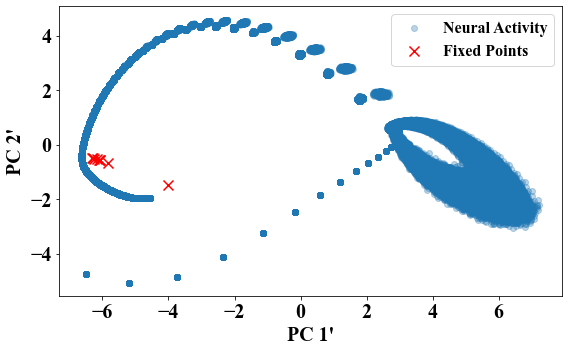

In [ ]:
activity_list = []
for trial_activity in leaky_activity_dict.values():
    activity_list.append(trial_activity) 
activity = np.vstack(activity_list)  


fixed_points_array = np.vstack(fixed_points) 

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)

activity_and_fp = np.concatenate([activity, fixed_points_array], axis=0) 


print(fixed_points_array.shape)

pca.fit(activity_and_fp)
print(activity.shape)
print(fixed_points_array.shape)

activity_pc = pca.transform(activity)
fixed_points_pc = pca.transform(fixed_points_array)

plt.figure(figsize=(8, 5))
plt.scatter(activity_pc[:, 0], activity_pc[:, 1], alpha=0.3, label='Neural Activity')
plt.scatter(fixed_points_pc[:, 0], fixed_points_pc[:, 1], color='red', marker='x', s=100, label='Fixed Points')


plt.xlabel("PC 1'", fontsize=20, fontweight='bold', fontfamily='Times New Roman')
plt.ylabel("PC 2'", fontsize=20, fontweight='bold', fontfamily='Times New Roman')

plt.legend(
    prop={
        'size': 16,
        'weight': 'bold',
        'family': 'Times New Roman'
    },
    loc='best'
)


plt.xticks(fontsize=20, fontweight='bold', fontfamily='Times New Roman')
plt.yticks(fontsize=20, fontweight='bold', fontfamily='Times New Roman')

save_path_leaky = r"C:\Users\jidon\OneDrive - University of Bristol\Home Desktop\Year4\Cog AI\Coursework\Pic\Leaky_RNN_task2_plot_fp_PCA.png"
plt.tight_layout()
plt.savefig(save_path_leaky, dpi=600, bbox_inches='tight', facecolor='white', edgecolor='white')

plt.show()


Searching for fixed points from 100 initial states.

	Freezing model parameters so model is not affected by fixed point optimization.
	Finding fixed points via joint optimization.
	Optimization complete to desired tolerance.
		823 iters
		q = 2.44e-13 +/- 2.56e-13
		dq = 1.46e-13 +/- 2.51e-13
		learning rate = 1.50e-01
		avg iter time = 1.13e-03 sec
	Identified 1 unique fixed points.
		initial_states: 0 outliers detected (of 100).
		fixed points: 0 outliers detected (of 1).
	Computing recurrent Jacobian at 1 unique fixed points.
	Computing input Jacobian at 1 unique fixed points.
	Decomposing Jacobians in a single batch.
	Sorting by Eigenvalue magnitude.
	Fixed point finding complete.


Searching for fixed points from 100 initial states.

	Freezing model parameters so model is not affected by fixed point optimization.
	Finding fixed points via joint optimization.
	Optimization complete to desired tolerance.
		1455 iters
		q = 4.47e-13 +/- 1.85e-13
		dq = 1.86e-13 +/- 1.46e-13
		learni

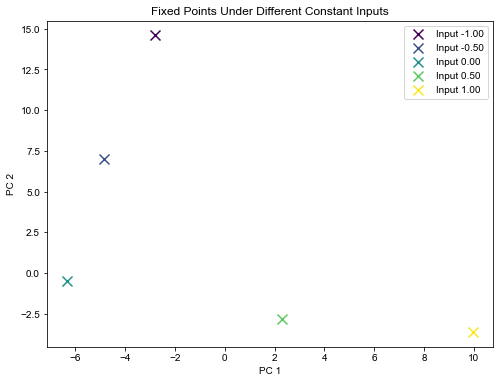

In [ ]:

input_values = np.linspace(-1, 1, 5)  
fixed_points_by_input = []

for input_val in input_values:

    inputs_np = np.full((100, EI_RNN.input_size), input_val)  

    init_hidden_np = initial_conditions.cpu().numpy()

    fps_result = leaky_finder.find_fixed_points(initial_states=init_hidden_np, inputs=inputs_np)
    fps = fps_result[0]
    fixed_points_by_input.append((input_val, fps.xstar))

plt.figure(figsize=(8, 6))
colors = plt.cm.viridis(np.linspace(0, 1, len(input_values)))

for idx, (input_val, fp_array) in enumerate(fixed_points_by_input): 
    fp_pc = pca.transform(fp_array)
    plt.scatter(fp_pc[:, 0], fp_pc[:, 1], color=colors[idx], marker='x', s=100, label=f'Input {input_val:.2f}')

plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('Fixed Points Under Different Constant Inputs')
plt.legend()
plt.show()

(array([-7.5, -5. , -2.5,  0. ,  2.5,  5. ,  7.5, 10. , 12.5, 15. , 17.5]),
 [Text(0, -7.5, '−7.5'),
  Text(0, -5.0, '−5.0'),
  Text(0, -2.5, '−2.5'),
  Text(0, 0.0, '0.0'),
  Text(0, 2.5, '2.5'),
  Text(0, 5.0, '5.0'),
  Text(0, 7.5, '7.5'),
  Text(0, 10.0, '10.0'),
  Text(0, 12.5, '12.5'),
  Text(0, 15.0, '15.0'),
  Text(0, 17.5, '17.5')])

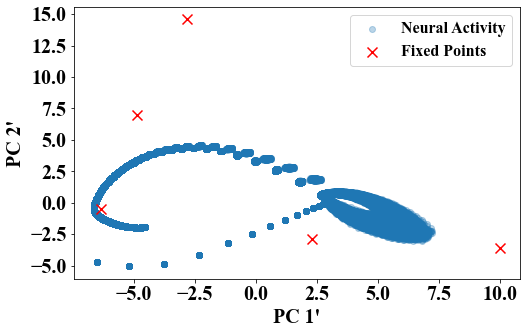

In [59]:
fixed_point_matrices = [np.array(item[1]) for item in fixed_points_by_input]
fixed_point_matrices = np.array(fixed_point_matrices).squeeze()
fixed_point_matrices.shape

new_activity_and_fp = np.concatenate([activity, fixed_point_matrices], axis=0)

new_activity_and_fp.shape

new_pca = PCA(n_components=2)

new_pca.fit(new_activity_and_fp)

new_activity_pc = new_pca.transform(activity)
new_fixed_points_pc = new_pca.transform(fixed_point_matrices)

plt.figure(figsize=(8, 5))
plt.scatter(new_activity_pc[:, 0], new_activity_pc[:, 1], alpha=0.3, label='Neural Activity')
plt.scatter(new_fixed_points_pc[:, 0], new_fixed_points_pc[:, 1], color='red', marker='x', s=100, label='Fixed Points')


plt.xlabel("PC 1'", fontsize=20, fontweight='bold', fontfamily='Times New Roman')
plt.ylabel("PC 2'", fontsize=20, fontweight='bold', fontfamily='Times New Roman')

plt.legend(
    prop={
        'size': 16,
        'weight': 'bold',
        'family': 'Times New Roman'
    },
    loc='best'
)


plt.xticks(fontsize=20, fontweight='bold', fontfamily='Times New Roman')
plt.yticks(fontsize=20, fontweight='bold', fontfamily='Times New Roman')


(array([-7.5, -5. , -2.5,  0. ,  2.5,  5. ,  7.5, 10. , 12.5, 15. , 17.5]),
 [Text(0, -7.5, '−7.5'),
  Text(0, -5.0, '−5.0'),
  Text(0, -2.5, '−2.5'),
  Text(0, 0.0, '0.0'),
  Text(0, 2.5, '2.5'),
  Text(0, 5.0, '5.0'),
  Text(0, 7.5, '7.5'),
  Text(0, 10.0, '10.0'),
  Text(0, 12.5, '12.5'),
  Text(0, 15.0, '15.0'),
  Text(0, 17.5, '17.5')])

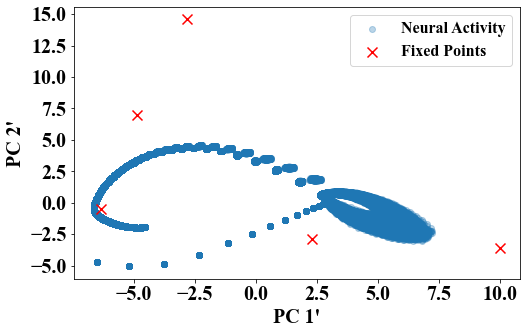

In [60]:

new_activity_and_fp = np.concatenate([activity, fixed_point_matrices], axis=0)

pca.fit(new_activity_and_fp)
#print(activity.shape)
#print(fixed_point_matrices.shape)

new_activity_pc = pca.transform(activity)
new_fixed_points_pc = pca.transform(fixed_point_matrices)

plt.figure(figsize=(8, 5))
plt.scatter(new_activity_pc[:, 0], new_activity_pc[:, 1], alpha=0.3, label='Neural Activity')
plt.scatter(new_fixed_points_pc[:, 0], new_fixed_points_pc[:, 1], color='red', marker='x', s=100, label='Fixed Points')


plt.xlabel("PC 1'", fontsize=20, fontweight='bold', fontfamily='Times New Roman')
plt.ylabel("PC 2'", fontsize=20, fontweight='bold', fontfamily='Times New Roman')

plt.legend(
    prop={
        'size': 16,
        'weight': 'bold',
        'family': 'Times New Roman'
    },
    loc='best'
)


plt.xticks(fontsize=20, fontweight='bold', fontfamily='Times New Roman')
plt.yticks(fontsize=20, fontweight='bold', fontfamily='Times New Roman')


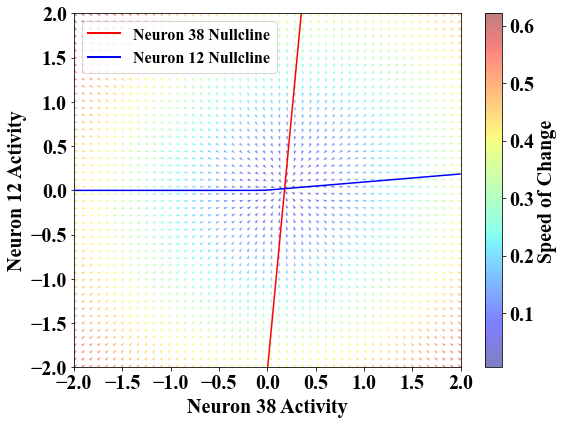

In [61]:
from matplotlib.lines import Line2D
from matplotlib.font_manager import FontProperties

selectivity_indices = np.argsort(np.abs(selectivity))[-2:]
neuron1, neuron2 = selectivity_indices

n_points = 50
state_range = np.linspace(-2, 2, n_points)
neuron1_states, neuron2_states = np.meshgrid(state_range, state_range)

grid_states = np.c_[neuron1_states.ravel(), neuron2_states.ravel()]

inputs = torch.zeros(grid_states.shape[0], EI_RNN.input_size).type(torch.float32)


initial_states = np.zeros((grid_states.shape[0], EI_RNN.rnn.hidden_size))
initial_states[:, neuron1] = grid_states[:, 0]
initial_states[:, neuron2] = grid_states[:, 1]


initial_states_tensor = torch.from_numpy(initial_states).type(torch.float32)


_, next_states = Leaky_RNN.rnn(inputs.unsqueeze(0), initial_states_tensor)
next_states = next_states.detach().cpu().numpy()


d_neuron1 = next_states[:, neuron1] - initial_states[:, neuron1]
d_neuron2 = next_states[:, neuron2] - initial_states[:, neuron2]


d_neuron1_grid = d_neuron1.reshape(neuron1_states.shape)
d_neuron2_grid = d_neuron2.reshape(neuron2_states.shape)


U = d_neuron1_grid  
V = d_neuron2_grid  

speed = np.sqrt(U**2 + V**2)
U_norm = U / speed
V_norm = V / speed


plt.figure(figsize=(8, 6))
plt.contour(neuron1_states, neuron2_states, d_neuron1_grid, levels=[0], colors='red')
plt.contour(neuron1_states, neuron2_states, d_neuron2_grid, levels=[0], colors='blue')
quiver = plt.quiver(neuron1_states, neuron2_states, U_norm, V_norm, speed, cmap='jet', alpha=0.5)


legend_elements = [
    Line2D([0], [0], color='red', lw=2, label=f'Neuron {neuron1} Nullcline'),
    Line2D([0], [0], color='blue', lw=2, label=f'Neuron {neuron2} Nullcline')
]


plt.legend(
    handles=legend_elements,
    loc='upper left',
    prop={
        'size': 16,  
        'weight': 'bold',
        'family': 'Times New Roman'
    }
)


plt.xlabel(f'Neuron {neuron1} Activity', fontsize=20, fontweight='bold', fontfamily='Times New Roman')
plt.ylabel(f'Neuron {neuron2} Activity', fontsize=20, fontweight='bold', fontfamily='Times New Roman')


plt.xticks(fontsize=20, fontweight='bold', fontfamily='Times New Roman')
plt.yticks(fontsize=20, fontweight='bold', fontfamily='Times New Roman')


cbar = plt.colorbar(quiver)
cbar.set_label('Speed of Change', fontsize=20, fontweight='bold', fontfamily='Times New Roman')
cbar.ax.tick_params(labelsize=20)
for label in cbar.ax.get_yticklabels():
    label.set_fontweight('bold')
    label.set_fontfamily('Times New Roman')

save_path_leaky = r"C:\Users\jidon\OneDrive - University of Bristol\Home Desktop\Year4\Cog AI\Coursework\Pic\Leaky_RNN_task2_plot_nuclines.png"
plt.tight_layout()
plt.savefig(save_path_leaky, dpi=600, bbox_inches='tight', facecolor='white', edgecolor='white')

plt.show()

In [62]:
print(neuron1, neuron2)
print(selectivity)

38 12
[ 7.6719649e-02  8.3768862e-01  0.0000000e+00  0.0000000e+00
 -4.2852533e-01  5.6720227e-01  4.2185784e-06  5.2765673e-01
  0.0000000e+00 -5.7983822e-01 -7.1408555e-02  2.7003199e-01
  1.1610625e+00  8.3006972e-01  7.3019505e-06 -5.7442671e-01
  1.7335363e-01  4.5186752e-01 -1.5595211e-01  1.5166047e-01
 -5.8684445e-06 -1.1375547e-01  7.8676885e-01  0.0000000e+00
 -2.5223064e-01  9.0661354e-02  4.7773076e-03  2.6795611e-02
  1.7908132e-01  0.0000000e+00  0.0000000e+00 -2.0054524e-01
  1.3484186e-01  0.0000000e+00 -3.9513472e-02  0.0000000e+00
  5.5828702e-02 -5.0437111e-02 -9.8613471e-01 -1.6584441e-01
  6.4643768e-06  1.5132955e-01  0.0000000e+00  1.2908354e-01
 -1.9950198e-01  0.0000000e+00 -3.0367094e-01  1.7483626e-02
  0.0000000e+00 -7.3582135e-02]
